In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Step 1: Download and Load the Dataset

- This step downloads the "Adult Income" dataset from the UCI Machine Learning Repository.
- The dataset is loaded into a Pandas DataFrame and given meaningful column names.
- Missing values are marked as NaN for easier handling in preprocessing.

In [7]:
def load_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    column_names = [
        "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
        "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
        "hours-per-week", "native-country", "income"
    ]
    df = pd.read_csv(url, header=None, names=column_names, na_values=" ?", skipinitialspace=True)
    return df

# Load dataset
raw_data = load_dataset()
print("Dataset Head:")
print(raw_data.head()) 

Dataset Head:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             

# Step 2: Preprocess the Dataset

- **Dropping Missing Values:** Ensures the dataset is clean and ready for training.
- **Encoding Categorical Variables:** Converts non-numerical columns into numeric format using `LabelEncoder`, which is necessary for ML models to process categorical data.
- **Feature-Target Separation:** Splits the data into features (X) and the target variable (y).
- **Standardization:** Scales numerical features to have zero mean and unit variance, which helps the model converge faster during training.
- **Train-Test Split:** Divides the dataset into training and test sets for model evaluation.

In [8]:
def preprocess_dataset(df):
    df = df.copy()

    # Skip the header row if it exists (the first row contains column names)
    if df.iloc[0, 0] == 'age':
        df = df.iloc[1:].reset_index(drop=True)
    
    # Convert numeric variables
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Encode categorical variables
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

    # Encode the target variable
    df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

    # Drop rows with missing values
    df = df.dropna()

    # Separate features and target
    X = df.drop("income", axis=1)
    y = df["income"]

    # Standardize numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

X, y = preprocess_dataset(raw_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the MLP using PyTorch

- **Model Architecture:**
  - The MLP has an input layer, one (or more additional) hidden layer, and an output layer.
  - `ReLU` is used in the hidden layer to introduce non-linearity and help the model learn complex patterns.
  - `Sigmoid` function is applied at the output layer to produce probabilities for binary classification.
- **`forward` Method:** Specifies how the input data flows through the layers during a forward pass.

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(MLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Add additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Use Sigmoid for binary classification
        layers.append(nn.Sigmoid())

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Step 4: Define Model Training Process

### For MLP
  - **Model Initialization:**
    - `input_dim`, `hidden_dim`, and `output_dim` define the dimensions of the input features, hidden layer, and output.
  - **Loss Function:** `BCELoss` is used for binary classification tasks.
  - **Optimizer:** `SGD` adjusts weights to minimize the loss, with a learning rate of 0.1.
  - **Training Loop:**
    - Performs forward and backward passes for 1000 epochs.
    - Tracks and minimizes the loss through gradient descent.
  - **Visualization:** Plots the training loss over epochs to monitor convergence.


In [10]:
# Abstract the model training process
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=1000):
    model.train()
    train_losses = []
    start_time = time.time()
    for epoch in range(num_epochs):

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    training_time = time.time() - start_time
    print(f"Model: {model.__class__.__name__}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Criterion: {criterion.__class__.__name__}")
    print(f"Hyperparameters: {num_epochs} epochs")
    print(f"Training time: {training_time:.2f} seconds")

    return train_losses

# Step 5: Define Model Evaluation Process
- **Evaluation Function:**
  - Sets the model to evaluation mode using `model.eval()`.
  - Makes predictions by thresholding the output probabilities at 0.5 for binary classification.
  - Calculates binary classification metrics by comparing predictions to actual labels.
- **Results:** Displays metrics for both training and test datasets to assess model performance.

In [11]:
# Evaluate model with additional metrics
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        predictions = logits > 0.5

        # Convert to numpy for sklearn
        y_np = y.cpu().numpy()
        preds_np = predictions.cpu().numpy()
        probs_np = logits.sigmoid().cpu().numpy()  # Ensure probabilities for AUC

        # Compute metrics
        accuracy = accuracy_score(y_np, preds_np)
        precision = precision_score(y_np, preds_np, zero_division=0)
        recall = recall_score(y_np, preds_np, zero_division=0)
        f1 = f1_score(y_np, preds_np, zero_division=0)
        auc_roc = roc_auc_score(y_np, probs_np)
        
    return accuracy, precision, recall, f1, auc_roc

# Step 6: Experimentation
- Configure global experimentation settings of the MLP
- Train and test MLP
- Experiment on different configurations of MLP

In [12]:
# Global experiment settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Model default parameters
fixed_input_dim = X_train.shape[1]
fixed_hidden_dim = 64
fixed_output_dim = 1
fixed_num_layers = 1

# Hyperparameters
fixed_epochs = 1000
fixed_lr = 0.01

Training with 16 neurons and 1 hidden layer(s)...
Epoch 100/1000, Loss: 0.6317
Epoch 200/1000, Loss: 0.5772
Epoch 300/1000, Loss: 0.5463
Epoch 400/1000, Loss: 0.5245
Epoch 500/1000, Loss: 0.5073
Epoch 600/1000, Loss: 0.4929
Epoch 700/1000, Loss: 0.4805
Epoch 800/1000, Loss: 0.4695
Epoch 900/1000, Loss: 0.4597
Epoch 1000/1000, Loss: 0.4507
Model: MLP
Optimizer: SGD
Criterion: BCELoss
Hyperparameters: 1000 epochs
Training time: 2.05 seconds
Training Accuracy: 0.7656, Precision: 0.9365, Recall: 0.0282, F1 Score: 0.0548, AUC-ROC: 0.8202
Test Accuracy: 0.7668, Precision: 0.9194, Recall: 0.0363, F1 Score: 0.0698, AUC-ROC: 0.8270




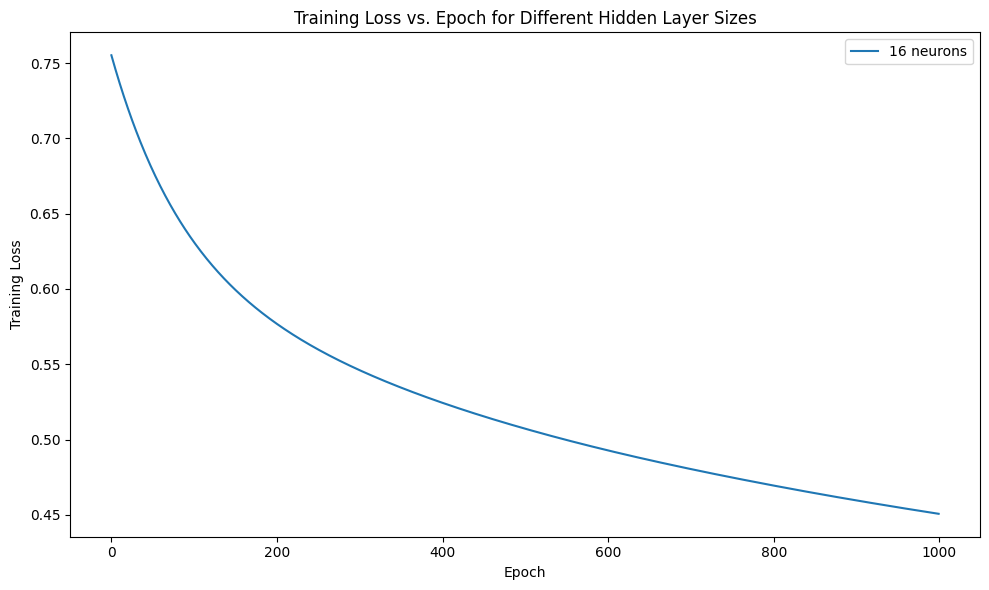

In [ ]:
# List of neuron options for the hidden layer
neuron_options = [8, 16, 32, 64, 128, 256, 512, 1024]

# Dictionaries to store performance metrics and loss curves for each configuration
performance_results = {}
loss_curves = {}

# Loop over each hidden layer size option
for hidden_layer_size in neuron_options:
    print(f"Training with {hidden_layer_size} neurons and {fixed_num_layers} hidden layer(s)...")
    
    # Initialize the model with the current hidden layer size and fixed number of hidden layers
    model = MLP(fixed_input_dim, hidden_layer_size, fixed_output_dim, num_layers=fixed_num_layers).to(device)
    
    # Define the optimizer and loss criterion
    optimizer = optim.SGD(model.parameters(), lr=fixed_lr)
    criterion = nn.BCELoss()
    
    # Train the model and record the training loss history
    train_losses = train_model(
        model, optimizer, criterion,
        X_train_tensor, y_train_tensor,
        X_test_tensor, y_test_tensor,
        num_epochs=fixed_epochs
    )
    loss_curves[hidden_layer_size] = train_losses
    
    # Evaluate model performance on training and test sets
    train_metrics = evaluate_model(model, X_train_tensor, y_train_tensor)
    test_metrics = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    performance_results[hidden_layer_size] = {
        "train_accuracy": train_metrics[0],
        "test_accuracy": test_metrics[0],
        "train_precision": train_metrics[1],
        "test_precision": test_metrics[1],
        "train_recall": train_metrics[2],
        "test_recall": test_metrics[2],
        "train_f1_score": train_metrics[3],
        "test_f1_score": test_metrics[3],
        "train_auc_roc": train_metrics[4],
        "test_auc_roc": test_metrics[4]
    }
    
    # Print the performance metrics
    print(f"Training Accuracy: {train_metrics[0]:.4f}, Precision: {train_metrics[1]:.4f}, "
          f"Recall: {train_metrics[2]:.4f}, F1 Score: {train_metrics[3]:.4f}, AUC-ROC: {train_metrics[4]:.4f}")
    print(f"Test Accuracy: {test_metrics[0]:.4f}, Precision: {test_metrics[1]:.4f}, "
          f"Recall: {test_metrics[2]:.4f}, F1 Score: {test_metrics[3]:.4f}, AUC-ROC: {test_metrics[4]:.4f}")
    print("\n")

# Plot training loss curves for different hidden layer sizes
plt.figure(figsize=(10, 6))
for hidden_layer_size, losses in loss_curves.items():
    plt.plot(losses, label=f"{hidden_layer_size} neurons")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epoch for Different Hidden Layer Sizes")
plt.legend()
plt.tight_layout()
plt.show()


Training with 64 neurons and 1 hidden layers...
Epoch 100/1000, Loss: 0.5507
Epoch 200/1000, Loss: 0.5112
Epoch 300/1000, Loss: 0.4842
Epoch 400/1000, Loss: 0.4635
Epoch 500/1000, Loss: 0.4472
Epoch 600/1000, Loss: 0.4344
Epoch 700/1000, Loss: 0.4242
Epoch 800/1000, Loss: 0.4159
Epoch 900/1000, Loss: 0.4092
Epoch 1000/1000, Loss: 0.4037
Model: MLP
Optimizer: SGD
Criterion: BCELoss
Hyperparameters: 1000 epochs
Training time: 7.08 seconds
Training Accuracy: 0.8174, Precision: 0.7540, Recall: 0.3584, F1 Score: 0.4858, AUC-ROC: 0.8509
Test Accuracy: 0.8201, Precision: 0.7635, Recall: 0.3679, F1 Score: 0.4966, AUC-ROC: 0.8558


Training with 64 neurons and 3 hidden layers...
Epoch 100/1000, Loss: 0.6007
Epoch 200/1000, Loss: 0.5622
Epoch 300/1000, Loss: 0.5424
Epoch 400/1000, Loss: 0.5300
Epoch 500/1000, Loss: 0.5192
Epoch 600/1000, Loss: 0.5082
Epoch 700/1000, Loss: 0.4961
Epoch 800/1000, Loss: 0.4833
Epoch 900/1000, Loss: 0.4701
Epoch 1000/1000, Loss: 0.4571
Model: MLP
Optimizer: SGD
Crit

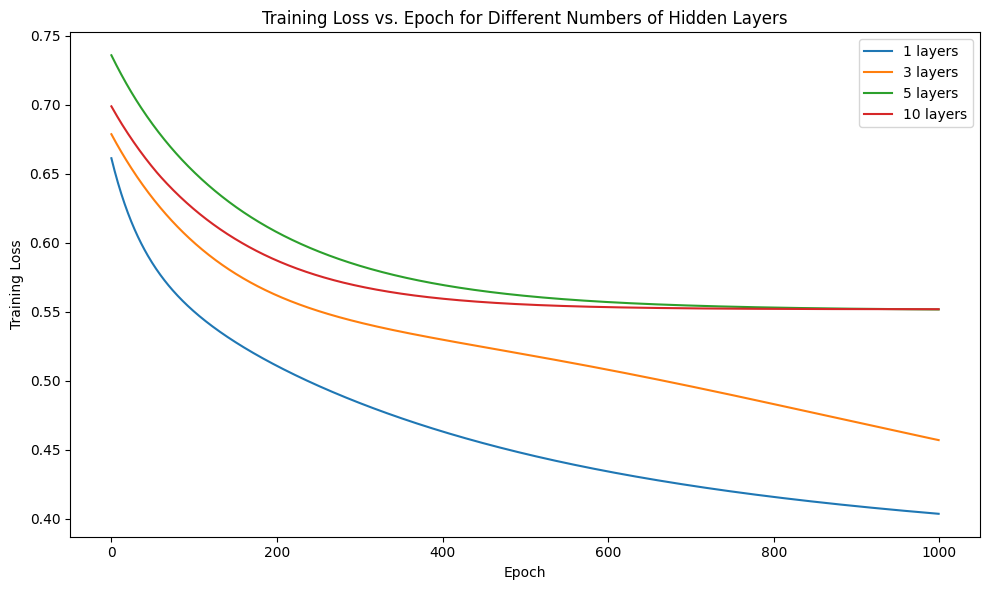

In [17]:
# List of different numbers of hidden layers to experiment with
num_layers_options = [1, 3, 5, 10]

# Dictionaries to store performance metrics and loss curves for each configuration
performance_results = {}
loss_curves = {}

# Loop through each number of hidden layers
for num_layers in num_layers_options:
    print(f"Training with {fixed_hidden_dim} neurons and {num_layers} hidden layers...")
    
    # Initialize the MLP model with the current number of hidden layers
    model = MLP(fixed_input_dim, fixed_hidden_dim, fixed_output_dim, num_layers=num_layers).to(device)
    
    # Define the optimizer and loss criterion
    optimizer = optim.SGD(model.parameters(), lr=fixed_lr)
    criterion = nn.BCELoss()

    # Train the model and record the loss curve over epochs
    train_losses = train_model(
        model, optimizer, criterion,
        X_train_tensor, y_train_tensor,
        X_test_tensor, y_test_tensor,
        num_epochs=fixed_epochs
    )
    loss_curves[num_layers] = train_losses
    
    # Evaluate performance on training and test sets
    train_accuracy, train_precision, train_recall, train_f1_score, train_auc_roc = evaluate_model(model, X_train_tensor, y_train_tensor)
    test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    # Store the evaluation metrics
    performance_results[num_layers] = {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_precision": train_precision,
        "test_precision": test_precision,
        "train_recall": train_recall,
        "test_recall": test_recall,
        "train_f1_score": train_f1_score,
        "test_f1_score": test_f1_score,
        "train_auc_roc": train_auc_roc,
        "test_auc_roc": test_auc_roc
    }
    
    # Print the performance metrics for the current configuration
    print(f"Training Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1_score:.4f}, AUC-ROC: {train_auc_roc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1_score:.4f}, AUC-ROC: {test_auc_roc:.4f}")
    print("\n")

# Plot the training loss curves for each configuration
plt.figure(figsize=(10, 6))
for num_layers, losses in loss_curves.items():
    plt.plot(losses, label=f"{num_layers} layers")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epoch for Different Numbers of Hidden Layers")
plt.legend()
plt.tight_layout()
plt.show()

Training with learning rate 0.001...
Epoch 100/1000, Loss: 0.6281
Epoch 200/1000, Loss: 0.6089
Epoch 300/1000, Loss: 0.5933
Epoch 400/1000, Loss: 0.5803
Epoch 500/1000, Loss: 0.5693
Epoch 600/1000, Loss: 0.5599
Epoch 700/1000, Loss: 0.5518
Epoch 800/1000, Loss: 0.5447
Epoch 900/1000, Loss: 0.5384
Epoch 1000/1000, Loss: 0.5327
Model: MLP
Optimizer: SGD
Criterion: BCELoss
Hyperparameters: 1000 epochs
Training time: 7.93 seconds
Training Accuracy: 0.7597, Precision: 0.9167, Recall: 0.0018, F1 Score: 0.0035, AUC-ROC: 0.7318
Test Accuracy: 0.7591, Precision: 1.0000, Recall: 0.0013, F1 Score: 0.0025, AUC-ROC: 0.7324

Training with learning rate 0.1...
Epoch 100/1000, Loss: 0.4040
Epoch 200/1000, Loss: 0.3793
Epoch 300/1000, Loss: 0.3642
Epoch 400/1000, Loss: 0.3524
Epoch 500/1000, Loss: 0.3441
Epoch 600/1000, Loss: 0.3385
Epoch 700/1000, Loss: 0.3349
Epoch 800/1000, Loss: 0.3325
Epoch 900/1000, Loss: 0.3308
Epoch 1000/1000, Loss: 0.3295
Model: MLP
Optimizer: SGD
Criterion: BCELoss
Hyperparam

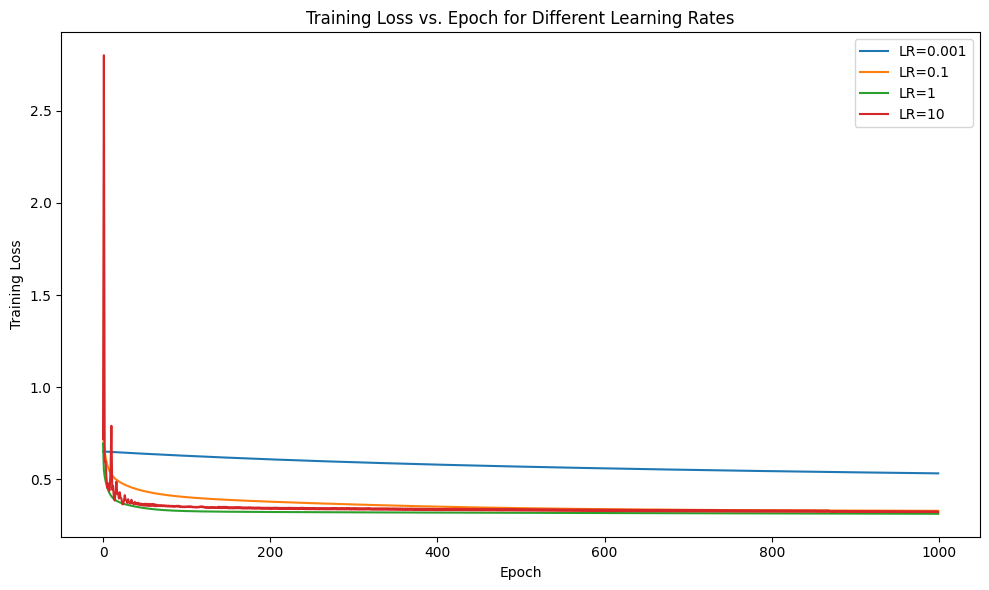

In [15]:
# Experiment with different learning rates
learning_rate_options = [0.001, 0.1, 1, 10]
performance_results = {}
loss_curves = {}

for learning_rate in learning_rate_options:
    print(f"Training with learning rate {learning_rate}...")
    
    # Initialize the model with fixed parameters and move it to the designated device
    model = MLP(fixed_input_dim, fixed_hidden_dim, fixed_output_dim, num_layers=fixed_num_layers).to(device)
    
    # Set up the optimizer and loss criterion using the current learning rate
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Train the model and record the loss curve over epochs
    train_losses = train_model(
        model, optimizer, criterion,
        X_train_tensor, y_train_tensor,
        X_test_tensor, y_test_tensor,
        num_epochs=fixed_epochs
    )
    loss_curves[learning_rate] = train_losses
    
    # Evaluate performance metrics on training and test data
    train_accuracy, train_precision, train_recall, train_f1_score, train_auc_roc = evaluate_model(model, X_train_tensor, y_train_tensor)
    test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    # Store the performance metrics for the current learning rate
    performance_results[learning_rate] = {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_precision": train_precision,
        "test_precision": test_precision,
        "train_recall": train_recall,
        "test_recall": test_recall,
        "train_f1_score": train_f1_score,
        "test_f1_score": test_f1_score,
        "train_auc_roc": train_auc_roc,
        "test_auc_roc": test_auc_roc
    }
    
    # Print the performance results
    print(f"Training Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, "
          f"F1 Score: {train_f1_score:.4f}, AUC-ROC: {train_auc_roc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, "
          f"F1 Score: {test_f1_score:.4f}, AUC-ROC: {test_auc_roc:.4f}\n")

# Plot the training loss curves for different learning rates
plt.figure(figsize=(10, 6))
for lr, losses in loss_curves.items():
    plt.plot(losses, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epoch for Different Learning Rates")
plt.legend()
plt.tight_layout()
plt.show()